### 1. Imports and Load Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier  # <-- IMPORTING THE MORE POWERFUL MODEL
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Load Data ---
file_path = '../data/processed/cleaned_loan_data.csv'
try:
    df = pd.read_csv(file_path)
    print("Cleaned data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file {file_path} was not found. Please run the first notebook to generate it.")

Cleaned data loaded successfully.


### 3. Advanced Feature Engineering

In [10]:
# --- Advanced Feature Engineering ---

# 1. Convert time-string columns to numerical (total months)
def convert_time_to_months(time_str):
    if pd.isnull(time_str):
        return 0
    try:
        years = int(time_str.split('yrs')[0])
        months = int(time_str.split(' ')[1].split('mon')[0])
        return (years * 12) + months
    except:
        return 0

df['average_acct_age_months'] = df['average_acct_age'].apply(convert_time_to_months)
df['credit_history_length_months'] = df['credit_history_length'].apply(convert_time_to_months)

# 2. Create flags for missing credit information (this is a very strong signal)
df['cns_score_missing'] = df['perform_cns_score'].apply(lambda x: 1 if x == 0 else 0)

# 3. Create a simple debt-to-asset ratio
# Add a small epsilon to asset_cost to avoid division by zero
df['debt_to_asset_ratio'] = df['disbursed_amount'] / (df['asset_cost'] + 0.01)

# 4. Drop original and unnecessary columns for modeling
cols_to_drop = [
'uniqueid', 'date_of_birth', 'disbursaldate',
'average_acct_age', 'credit_history_length'
]
df_model = df.drop(columns=cols_to_drop)

print("Advanced feature engineering complete.")
df_model[['average_acct_age_months', 'credit_history_length_months', 'cns_score_missing', 'debt_to_asset_ratio']].head()

Advanced feature engineering complete.


,average_acct_age_months,credit_history_length_months,cns_score_missing,debt_to_asset_ratio
0,0,0,1,0.866061
1,0,0,1,0.868285
2,0,0,1,0.868623
3,0,0,1,0.753642
4,0,0,1,0.557069


### 3.  Feature and Target Definition

In [ ]:
# --- Feature and Target Definition ---
X = df_model.drop('loan_default', axis=1)
y = df_model['loan_default']

# Identify numerical and categorical columns for the preprocessor
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")

Feature preparation complete.


### 3. Preprocessing Pipeline

In [12]:
# --- Feature and Target Definition ---
X = df_model.drop('loan_default', axis=1)
y = df_model['loan_default']

# Identify numerical and categorical columns for the preprocessor
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")

Number of numerical features: 38
Number of categorical features: 2


#### 4. Preprocessing Pipeline

In [13]:
# --- Create Preprocessing Pipeline ---
# This pipeline scales numerical features and one-hot encodes categorical features.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
],
remainder='passthrough'
)
print("Preprocessing pipeline created.")

Preprocessing pipeline created.


### 5. Train-Test Split

In [14]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 163207 samples
Test set size: 69947 samples


### 6. Build and Train the Improved Model Pipeline

In [15]:
# --- Build and Train the Improved Model ---
# We use LGBMClassifier, a powerful gradient boosting model.
# The 'is_unbalance=True' or 'scale_pos_weight' parameter is the LightGBM equivalent of 'class_weight=balanced'.
# Let's calculate scale_pos_weight for better performance.
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model_pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight))
])

# Train the entire pipeline on the training data
print("Training the LightGBM model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Training the LightGBM model...
[LightGBM] [Info] Number of positive: 35428, number of negative: 127779
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4962
[LightGBM] [Info] Number of data points in the train set: 163207, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217074 -> initscore=-1.282800
[LightGBM] [Info] Start training from score -1.282800
Model training complete.


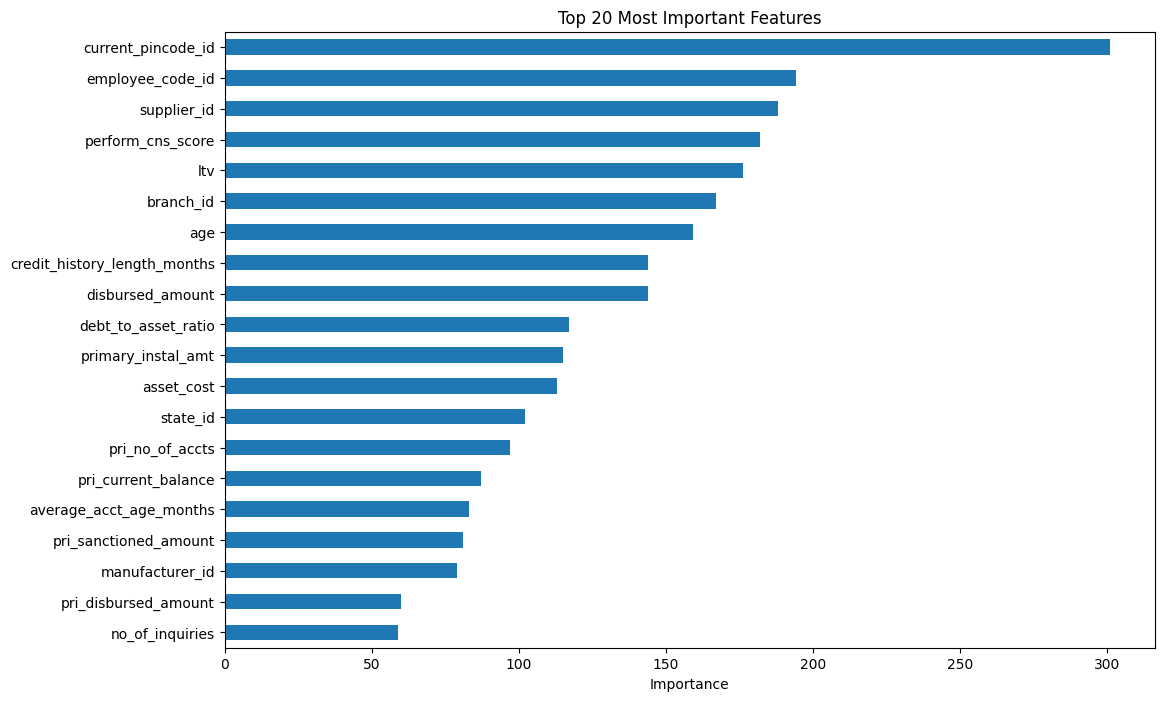

In [17]:
# --- Feature Importance Analysis ---
# Get the trained LGBMClassifier from the pipeline
lgbm_model = model_pipeline.named_steps['classifier']

# Get the feature names after one-hot encoding
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

# Create a pandas series for feature importances
importances = pd.Series(lgbm_model.feature_importances_, index=all_feature_names)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
importances.nlargest(20).sort_values().plot(kind='barh')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.savefig('../reports/figures/feature_importance.png', bbox_inches='tight')
plt.show()

### 7. Predictions and Evaluation

c:\Users\ThapeloMasebe\miniconda3\envs\loan_predictor_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model Accuracy: 59.68%

--- Classification Report ---
                precision    recall  f1-score   support

No Default (0)       0.86      0.58      0.69     54764
   Default (1)       0.30      0.66      0.42     15183

      accuracy                           0.60     69947
     macro avg       0.58      0.62      0.55     69947
  weighted avg       0.74      0.60      0.63     69947

--- Confusion Matrix ---


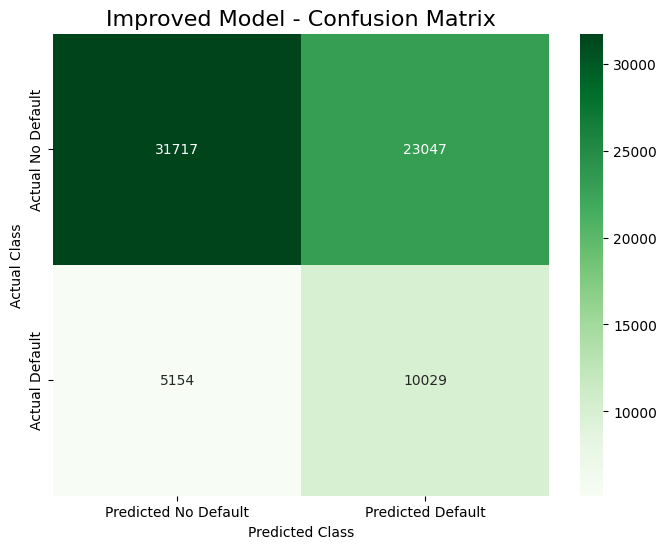

In [18]:
# --- Evaluate the Improved Model ---
# Make predictions on the test data
y_pred = model_pipeline.predict(X_test)

# 1. Accuracy Score
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")

# 2. Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Default (0)', 'Default (1)']))

# 3. Confusion Matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Changed color for the new model
        xticklabels=['Predicted No Default', 'Predicted Default'],
        yticklabels=['Actual No Default', 'Actual Default'])
plt.title('Improved Model - Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Save the figure
plt.savefig('../reports/figures/improved_confusion_matrix.png', bbox_inches='tight')
plt.show()